In [119]:
import pickle
path = 'dataset/pickle/greedy(test_audio_con)/ac26ZMwG7aT/1007419.pkl'

In [120]:
with open(path , 'rb') as f:
    data = pickle.load(f)

In [88]:
data.keys(
)

dict_keys(['obs', 'reward', 'done', 'action_id', 'info', 'map', 'path_point'])

In [73]:
data['reward']

[-1.01, -0.01, -1.01, -0.01, -0.01, 0.99, -0.01, 0.99, 0.99, 9.99]

In [96]:
data['obs'][2]['category']

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [97]:
data['obs'][0].keys()

dict_keys(['rgb', 'depth', 'spectrogram', 'category', 'pose', 'pose_gd'])

In [109]:
len(data['reward'])

32

In [101]:
data['obs'][2]['spectrogram'][1]

array([[ 0.00323189,  0.00380709,  0.00355894, ..., -0.00147385,
        -0.00169737, -0.00033214],
       [-0.00117328, -0.00119516, -0.00117229, ...,  0.0006929 ,
         0.00035952, -0.00107068]])

In [106]:
import numpy as np
import soundfile as sf

def save_audio_or_silence(audio_data, output_path, samplerate=16000, silence_threshold=1e-6):
    """
    如果音频能量过低，则保存为静音，否则保存归一化后的音频。
    audio_data: np.ndarray, shape (channels, samples) or (samples, channels)
    """
    audio_data = np.squeeze(audio_data)

    # 转成 (samples, channels)
    if audio_data.shape[0] < audio_data.shape[1]:
        audio_data = audio_data.T  

    # 计算能量
    max_val = np.max(np.abs(audio_data))

    if max_val < silence_threshold:
        print("⚠️ 音频能量过低，保存为静音。")
        audio_int16 = np.zeros_like(audio_data, dtype=np.int16)
    else:
        print(f"音频最大值 {max_val:.2e}，进行归一化保存。")
        audio_normalized = audio_data / max_val
        audio_int16 = (audio_normalized * 32767).astype(np.int16)

    sf.write(output_path, audio_int16, samplerate, subtype="PCM_16")
    print(f"保存完成：{output_path}, shape={audio_int16.shape}")

# 用法
save_audio_or_silence(data['obs'][6]['spectrogram'][1], "output.wav")


音频最大值 1.77e-03，进行归一化保存。
保存完成：output.wav, shape=(16000, 2)


In [121]:
import numpy as np
import soundfile as sf

def save_audio_or_silence(audio_data, output_path, samplerate=16000, silence_threshold=1e-6):
    """
    如果音频能量过低，则保存为静音，否则保存归一化后的音频。
    audio_data: np.ndarray, shape (channels, samples) or (samples, channels)
    """
    audio_data = np.squeeze(audio_data)

    # 转成 (samples, channels)
    if len(audio_data.shape) > 1 and audio_data.shape[0] < audio_data.shape[1]:
        audio_data = audio_data.T  

    # 计算能量
    max_val = np.max(np.abs(audio_data))

    if max_val < silence_threshold:
        print("⚠️ 音频能量过低，保存为静音。")
        audio_int16 = np.zeros_like(audio_data, dtype=np.int16)
    else:
        print(f"音频最大值 {max_val:.2e}，进行归一化保存。")
        audio_normalized = audio_data / max_val
        audio_int16 = (audio_normalized * 32767).astype(np.int16)

    sf.write(output_path, audio_int16, samplerate, subtype="PCM_16")
    print(f"保存完成：{output_path}, shape={audio_int16.shape}")

def combine_all_audio_data(data, output_path="combined_audio.wav", samplerate=16000):
    """
    将所有 data['obs'] 的音频数据合并成一个文件
    """
    all_audio_chunks = []
    
    print(f"开始处理 {len(data['obs'])} 个音频片段...")
    
    for i, obs in enumerate(data['obs']):
        if 'spectrogram' in obs and len(obs['spectrogram']) > 1:
            audio_chunk = obs['spectrogram'][1]
            
            # 预处理音频数据
            audio_chunk = np.squeeze(audio_chunk)
            
            # 转成 (samples, channels)
            if len(audio_chunk.shape) > 1 and audio_chunk.shape[0] < audio_chunk.shape[1]:
                audio_chunk = audio_chunk.T
            
            # 检查是否为静音
            max_val = np.max(np.abs(audio_chunk))
            if max_val < 1e-6:
                print(f"片段 {i}: 静音")
                # 创建静音片段（保持相同长度）
                if len(audio_chunk.shape) == 1:
                    silent_chunk = np.zeros_like(audio_chunk)
                else:
                    silent_chunk = np.zeros_like(audio_chunk)
                all_audio_chunks.append(silent_chunk)
            else:
                print(f"片段 {i}: 有声音 (最大值: {max_val:.2e})")
                # 归一化并添加到列表
                audio_normalized = audio_chunk / max_val
                all_audio_chunks.append(audio_normalized)
        else:
            print(f"片段 {i}: 无有效音频数据")
            # 创建默认静音片段（假设长度与其他相同）
            if all_audio_chunks:
                silent_shape = all_audio_chunks[0].shape
                all_audio_chunks.append(np.zeros(silent_shape))
    
    if not all_audio_chunks:
        print("错误：没有找到有效的音频数据")
        return
    
    # 合并所有音频片段
    print("正在合并音频片段...")
    combined_audio = np.concatenate(all_audio_chunks, axis=0)
    
    # 最终归一化
    combined_max = np.max(np.abs(combined_audio))
    if combined_max > 0:
        combined_audio = combined_audio / combined_max
    
    # 转换为 int16 并保存
    audio_int16 = (combined_audio * 32767).astype(np.int16)
    
    sf.write(output_path, audio_int16, samplerate, subtype="PCM_16")
    print(f"✅ 所有音频已合并保存至：{output_path}")
    print(f"合并后音频形状：{audio_int16.shape}")
    print(f"总时长：{len(audio_int16) / samplerate:.2f} 秒")

# 使用方法
combine_all_audio_data(data, "all_combined_audio.wav")

开始处理 17 个音频片段...
片段 0: 有声音 (最大值: 1.28e-03)
片段 1: 有声音 (最大值: 1.69e-02)
片段 2: 有声音 (最大值: 8.40e-03)
片段 3: 有声音 (最大值: 6.43e-03)
片段 4: 有声音 (最大值: 7.74e-03)
片段 5: 有声音 (最大值: 1.02e-02)
片段 6: 有声音 (最大值: 1.07e-02)
片段 7: 有声音 (最大值: 1.43e-03)
片段 8: 有声音 (最大值: 1.18e-02)
片段 9: 有声音 (最大值: 6.34e-03)
片段 10: 有声音 (最大值: 6.74e-03)
片段 11: 有声音 (最大值: 6.91e-03)
片段 12: 有声音 (最大值: 7.33e-03)
片段 13: 有声音 (最大值: 2.22e-02)
片段 14: 有声音 (最大值: 2.60e-02)
片段 15: 有声音 (最大值: 7.45e-02)
片段 16: 有声音 (最大值: 7.45e-02)
正在合并音频片段...
✅ 所有音频已合并保存至：all_combined_audio.wav
合并后音频形状：(272000, 2)
总时长：17.00 秒


In [116]:
from PIL import Image
import numpy as np

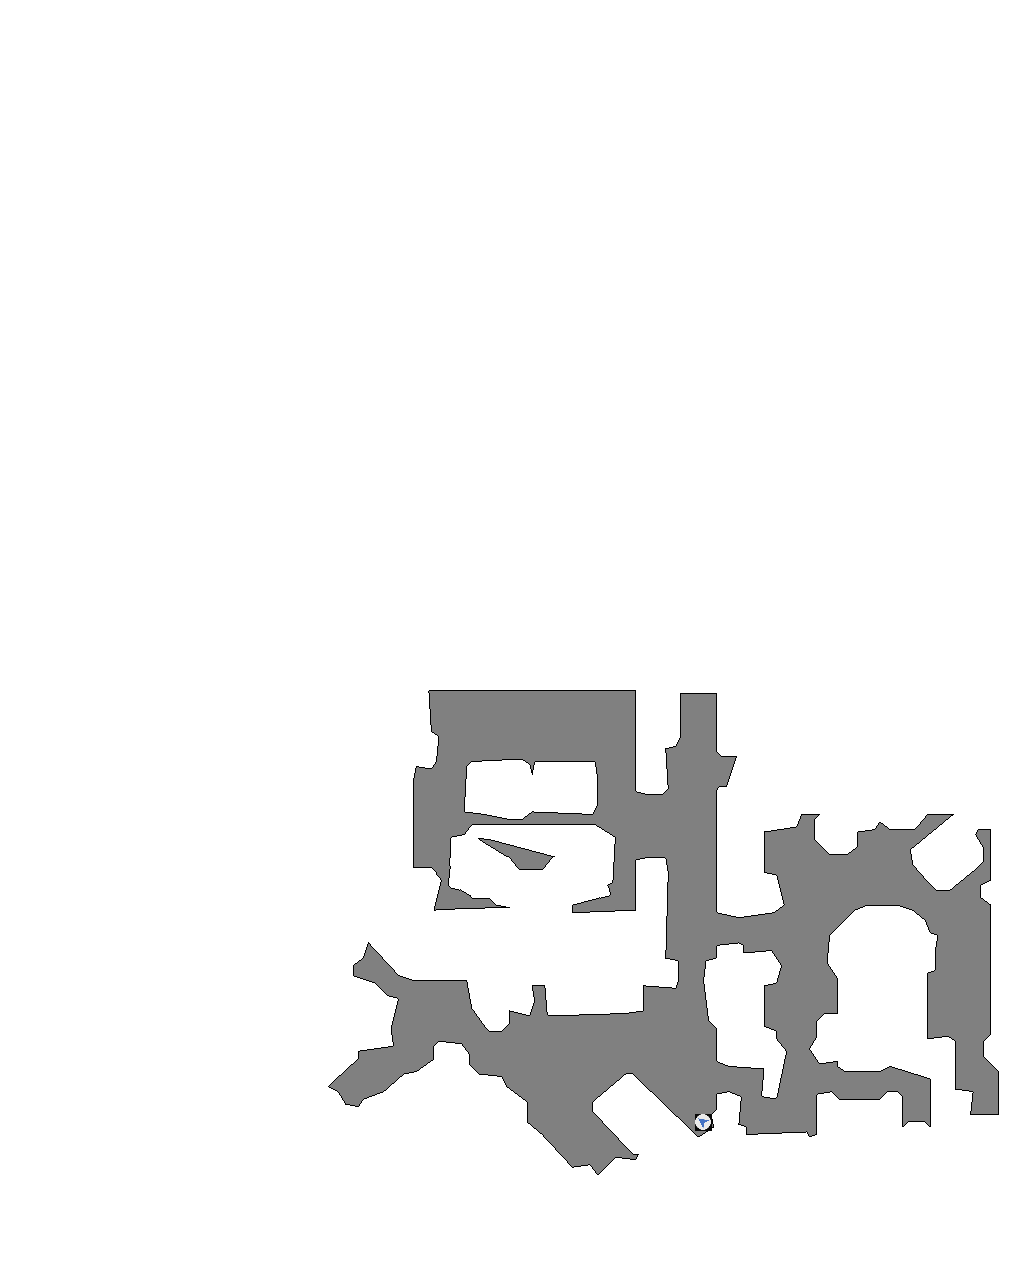

In [118]:
Image.fromarray(data['collided_map'][0])

In [36]:
data['action_id']

[[2, 1, 2, 1, 1, 1, 3, 1, 2, 1, 3, 1, 1, 3, 1, 2, 1, 3, 1, 2, 1, 0]]

In [37]:
len(data['reward'])

22

In [38]:
data['info']

[{'distance_to_goal': 10.0,
  'normalized_distance_to_goal': 0.8333333333333334,
  'success': 0.0,
  'spl': 0.0,
  'softspl': 0.0,
  'na': 1,
  'sna': 0.0,
  'sws': 0.0},
 {'distance_to_goal': 9.0,
  'normalized_distance_to_goal': 0.75,
  'success': 0.0,
  'spl': 0.0,
  'softspl': 0.09999999999999998,
  'na': 2,
  'sna': 0.0,
  'sws': 0.0},
 {'distance_to_goal': 9.0,
  'normalized_distance_to_goal': 0.75,
  'success': 0.0,
  'spl': 0.0,
  'softspl': 0.09999999999999998,
  'na': 3,
  'sna': 0.0,
  'sws': 0.0},
 {'distance_to_goal': 8.0,
  'normalized_distance_to_goal': 0.6666666666666666,
  'success': 0.0,
  'spl': 0.0,
  'softspl': 0.19999999999999996,
  'na': 4,
  'sna': 0.0,
  'sws': 0.0},
 {'distance_to_goal': 7.0,
  'normalized_distance_to_goal': 0.5833333333333334,
  'success': 0.0,
  'spl': 0.0,
  'softspl': 0.30000000000000004,
  'na': 5,
  'sna': 0.0,
  'sws': 0.0},
 {'distance_to_goal': 6.0,
  'normalized_distance_to_goal': 0.5,
  'success': 0.0,
  'spl': 0.0,
  'softspl': 0.4